In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms,models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [2]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])

In [3]:
dataset = datasets.ImageFolder(root='C:\\Ishwarya\\Python\\mydata1', transform=transform)

In [4]:
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))  # train_size
validation = int(np.floor(0.70 * split))  # validation
np.random.shuffle(indices)
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [5]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [7]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [8]:
vgg=models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\alagu/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth


In [9]:
for param in vgg.parameters():
    param.requires_grad=False

In [12]:
num_classes = 6
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [13]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([6, 4096])
torch.Size([6])


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg.parameters(), lr=0.05)

In [16]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world
            
        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}")

    return train_losses, validation_losses

In [19]:
batch_size = 64
train_loader = torch.utils.data.DataLoader( dataset, batch_size=batch_size, sampler=train_sampler)
test_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

In [20]:
train_losses, validation_losses = batch_gd(vgg, criterion, train_loader, validation_loader, 1)

Epoch : 1/1 Train_loss:0.299 Test_loss:0.186 Duration:0:18:27.286040


In [21]:
torch.save(vgg.state_dict() , 'plant_disease_model_1.pt')

In [22]:
targets_size = 2
#vgg = CNN(targets_size)
vgg.load_state_dict(torch.load("plant_disease_model_1.pt"))
vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

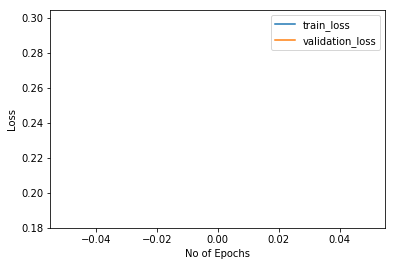

In [23]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = vgg(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [25]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [26]:
print(f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}")

Train Accuracy : 0.972107212900414
Test Accuracy : 0.957685664939551
Validation Accuracy : 0.9659379766141332


In [27]:
import pandas as pd
data=[['Apple_scab'],['Apple_healthy'],['BellPepper_Bacterial_spot'],['BellPepper_healthy'],['Tomato_Early_blight'],['Tomato_healthy']]
df=pd.DataFrame(data,columns=['disease_name'])

In [28]:
from PIL import Image
import torchvision.transforms.functional as TF

In [46]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = vgg(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[66:-4])
    pred_csv = df["disease_name"][index]
    print(pred_csv)

In [47]:
single_prediction("C:\\Users\\alagu\\Downloads\\Plant-Disease-Detection-main\\test_images\\pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
BellPepper_healthy
